In [5]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [6]:
#hide
from fastbook import *

# Lesson 6 video notes.

https://course.fast.ai/videos/?lesson=6

## On 05 chapter. 

CEL is important to understand.

To check model: confusion matrix, `most_confused`.
A model can do sensible mistakes, the smae that humans do.

Improving model. Changing learning rate. Discrimination LR. Unfreezing and transfer learning.

...

## On 6 chapter

From 30 min

Multiclas - zero or many labels.
Pandas important to learn.

Constructing a data block.
Dataset - anything we can index or get length. And typically with tuples.
DataLoader - takes datasets and iterates over that.

...

Why not float point of 8 bit? It is an area of active research. Model becomes flat. Probably it is possible with 1 bit.



# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [8]:
from fastai.vision.all import *


In [9]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [18]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [19]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [20]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [21]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [22]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [23]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [24]:
dblock = DataBlock()

In [25]:
dsets = dblock.datasets(df)

In [26]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [27]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [28]:
x['fname']

'008663.jpg'

In [29]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [30]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [31]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/art/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [32]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [33]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [34]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [35]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

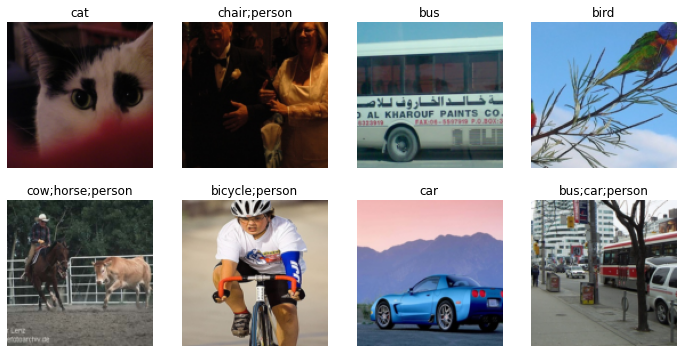

In [37]:
dls.show_batch(nrows=2, ncols=4)

In [16]:
mylist = list('dearest creature in creation')
myds = Datasets(mylist)
def f1(x): return x + 'a'
dss = Datasets(mylist, [[f1], [f1]])
dss

(#28) [('da', 'da'),('ea', 'ea'),('aa', 'aa'),('ra', 'ra'),('ea', 'ea'),('sa', 'sa'),('ta', 'ta'),(' a', ' a'),('ca', 'ca'),('ra', 'ra')...]

### Binary Cross-Entropy

This is about what loss function to use for a multicategory classification problem. Previously we used binary loss func (yes or no and the probability hence) and cross entropy loss which calculated probabilities for each category that sum up to 1. But here we can't use it as there can be many or no objects. How to calc now? Calc probabilities for each category and sum it up (but they won't sum up to one).

In [23]:
learn = cnn_learner(dls, resnet18)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [24]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [25]:
activs[0]

TensorBase([ 0.7476, -1.1988,  4.5421, -1.5915, -0.6749,  0.0343, -2.4930, -0.8330, -0.3817, -1.4876, -0.1683,  2.1547, -3.4151, -1.1743,  0.1530, -1.6801, -2.3067,  0.7063, -1.3358, -0.3715],
       grad_fn=<AliasBackward0>)

In [26]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [27]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0342, grad_fn=<AliasBackward0>)

In [28]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [29]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [30]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944758,0.700255,0.236594,00:30
1,0.823372,0.554367,0.300199,00:27
2,0.601386,0.199618,0.817769,00:28
3,0.358964,0.123707,0.945060,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.137788,0.117347,0.945697,00:33
1,0.118669,0.104139,0.950518,00:33
2,0.099040,0.102703,0.951494,00:33


In [31]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10270252078771591,0.9307370185852051]

In [32]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10270252078771591,0.9427290558815002]

In [33]:
preds,targs = learn.get_preds()

In [34]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9562)

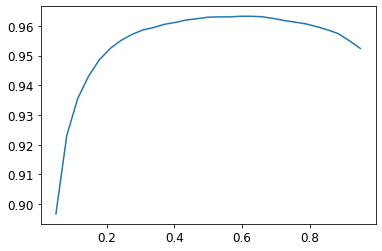

In [35]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the Data

In [10]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [11]:
#hide
Path.BASE_PATH = path

In [12]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [13]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [15]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('08/frame_00260_pose.txt')

In [16]:
im = PILImage.create(img_files[1])
im.shape

(480, 640)

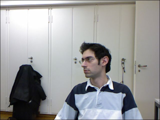

In [17]:
im.to_thumb(160)

In [18]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [19]:
get_ctr(img_files[0])

tensor([365.7415, 250.3084])

In [20]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

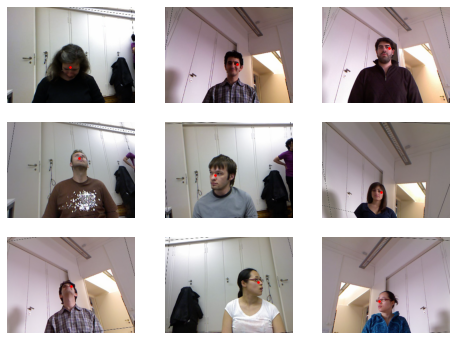

In [21]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [22]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [23]:
yb[0]

TensorPoint([[-0.1017,  0.2276]])

### Training a Model

In [61]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [62]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

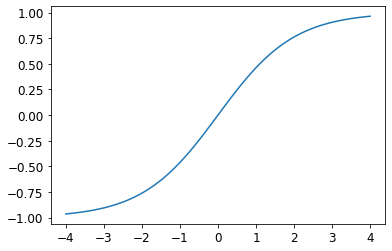

In [63]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [64]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

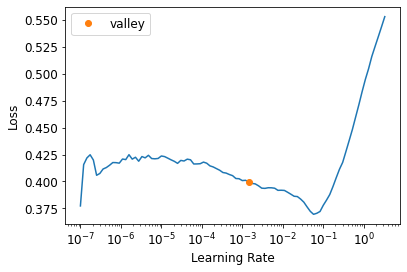

In [65]:
learn.lr_find()

In [67]:
lr = 0.0014454397605732083
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.013631,0.015403,03:43


epoch,train_loss,valid_loss,time
0,0.004134,0.000548,04:29
1,0.002523,0.000335,04:26
2,0.001938,0.000281,05:26


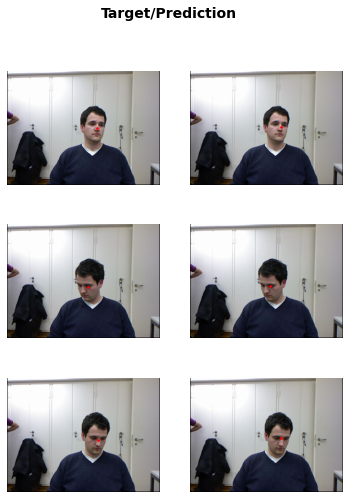

In [69]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?

It will be able to classify many objects at a picture or none at all contrast to classifying always one object at a picture.

1. How do we encode the dependent variable in a multi-label classification problem?

We represent it as a one-hot encoding that is a vector of 0s and 1s where an index of 1 represents a label index in targets.

1. How do you access the rows and columns of a DataFrame as if it was a matrix?

`df.iloc[rowstart:rowend, colstart:colend]` or `df.iloc[0,3]` - 0 row, 3 col.
dataframe.iloc - Integer LOCation. Selection in dimensions using various indexing: index, index slice, boolean array, func.

1. How do you get a column by name from a DataFrame?

DataFrame has _getitem_, i.e. can `df['colname']`

1. What is the difference between a `Dataset` and `DataLoader`?

Dataset - a tuple of dependent and independent variables (image and labels).
Dataloader - iterator over mini-batches to load data using datasets 
Datasets - wrapper around train and validation datasets.
Dataloaders - wrapper around 'DataLoader's objects.

1. What does a `Datasets` object normally contain?

Input and target variables.

1. What does a `DataLoaders` object normally contain?

Training and validation iterators over batches (DataLoader per train and valid).

1. What does `lambda` do in Python?

Unnamed func.

1. What are the methods to customize how the independent and dependent variables are created with the data block API?

`get_x` and `get_y`

1. Why is softmax not an appropriate output activation function when using a one hot encoded target?

Because multiple categories exist but softmax for categorizing only one category.

1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?

Cross Entropy Loss is not appropriate because many categories and there are many now.

1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?

It applies log

1. Why can't we use regular accuracy in a multi-label problem?

Need to specify threshold to get a boolean value per each item in a vector.

1. When is it okay to tune a hyperparameter on the validation set?

When it has smooth distribution.

1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)

It scales a point to some interval.

1. What is a regression problem? What loss function should you use for such a problem?

Regression is projecting an input into a number or numbers rather than finite set. The loss function for such a problem should be mean square error that calcs how far a prediction from a target.

1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

Need to specify correct blocks.


### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.